In [14]:
%matplotlib inline

Lets play around with a simple RBF network

First, lets generate some data (toy data set)

/var/folders/z5/b9yhk9k12l31fz69p714mhyw0000gn/T/ipykernel_57428/1268983543.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x1[:, 0], x1[:, 1], cmap='ob')
/var/folders/z5/b9yhk9k12l31fz69p714mhyw0000gn/T/ipykernel_57428/1268983543.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x2[:, 0], x2[:, 1], cmap='or')


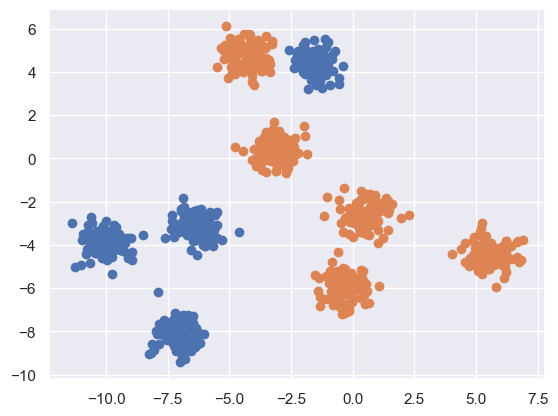

In [15]:
import torch
from torch.autograd import Variable
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# lets use sklearn to make 'blob' patterns (for a train set)
x1, junk = make_blobs(n_samples=400, centers=4, cluster_std=0.5, random_state=1)
x2, junk = make_blobs(n_samples=500, centers=5, cluster_std=0.5, random_state=667)
y1 = np.zeros(x1.shape[0]).astype(np.float64)
y2 = np.ones(x2.shape[0]).astype(np.float64)
plt.scatter(x1[:, 0], x1[:, 1], cmap='ob')
plt.scatter(x2[:, 0], x2[:, 1], cmap='or')
plt.show()

# combine 
xtrain = np.concatenate( (x1, x2) )
ytrain = np.concatenate( (y1, y2) )

Now, a test set, slightly larger std

/var/folders/z5/b9yhk9k12l31fz69p714mhyw0000gn/T/ipykernel_57428/2891106610.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tx1[:, 0], tx1[:, 1], cmap='ob')
/var/folders/z5/b9yhk9k12l31fz69p714mhyw0000gn/T/ipykernel_57428/2891106610.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tx2[:, 0], tx2[:, 1], cmap='or')


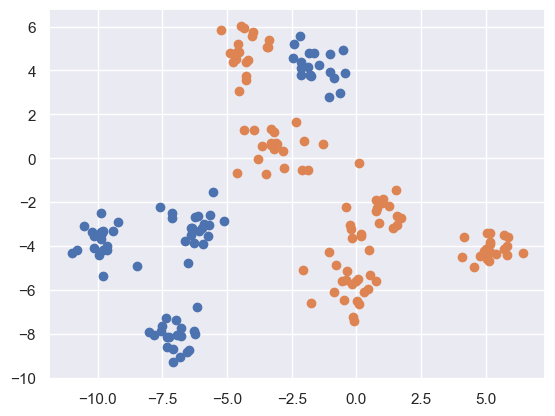

In [16]:
# lets use sklearn to make 'blob' patterns
tx1, junk = make_blobs(n_samples=80, centers=4, cluster_std=0.7, random_state=1)
tx2, junk = make_blobs(n_samples=100, centers=5, cluster_std=0.7, random_state=667)
ty1 = np.zeros(tx1.shape[0]).astype(np.float64)
ty2 = np.ones(tx2.shape[0]).astype(np.float64)
plt.scatter(tx1[:, 0], tx1[:, 1], cmap='ob')
plt.scatter(tx2[:, 0], tx2[:, 1], cmap='or')
plt.show()

# combine 
xtest = np.concatenate( (tx1, tx2) )
ytest = np.concatenate( (ty1, ty2) )

Now, we will cluster our data and create the RBFs

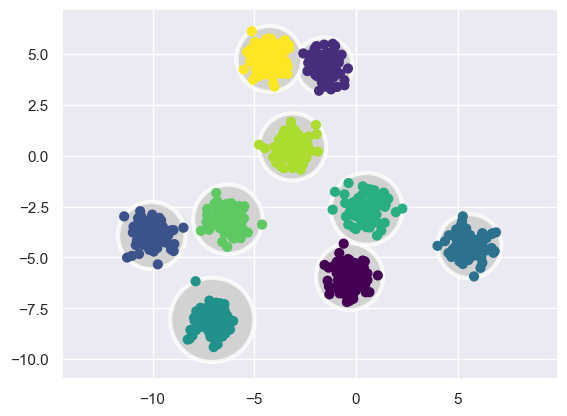

In [17]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# a plot helper routine
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.8, zorder=1))

# cluster class 1
kmeans = KMeans(9, random_state=0)
kmeans.fit(xtrain)
klabels = kmeans.predict(xtrain)
plot_kmeans(kmeans, xtrain, n_clusters=9)
plt.show()

clusters = kmeans.cluster_centers_.astype(float)

Now, lets seed those RBFs

Make design our RBF network, init it with means, unit sigmas

In [18]:
# make network
class RBFnet(nn.Module):
    def __init__(self, clusters):
        super(RBFnet, self).__init__()
        # remember how many centers we have
        self.N = clusters.shape[0]
        # our mean and sigmas for the RBF layer
        self.sigs = nn.Parameter( torch.ones(self.N,dtype=torch.float64)*5, requires_grad=False ) # our sigmas
        self.mus = nn.Parameter( torch.from_numpy(clusters), requires_grad=False ) # our means
        # our connection to the output layer
        self.lin = nn.Parameter( ((torch.rand(self.N,dtype=torch.float64)-0.5)*2.0)*(1.0/self.N), requires_grad=True)
        self.bias = nn.Parameter( ((torch.rand(1,dtype=torch.float64)-0.5)*2.0)*(1.0/self.N), requires_grad=True)
    def forward(self, x):
        # evaluate RBFs
        # you could do some matrix math and get rid of this for loop!!!!
        res = torch.zeros(x.shape[0],self.N,dtype=torch.float64)
        for i in range(x.shape[0]): # each data point
            for j in range(self.N): # each cluster
                top = torch.sqrt(((x[i,:]-self.mus[j,:])**2).sum(axis=0))
                res[i,j] = torch.exp( (-0.5) * ( torch.pow(top,2.0) / torch.pow(self.sigs[j],2.0) ) )
        y_pred = torch.zeros(x.shape[0],dtype=torch.float64)
        for i in range(x.shape[0]): # again, could speed up with matrix math!!!
            y_pred[i] = torch.sigmoid( torch.dot(res[i,:],self.lin) + self.bias )
        return y_pred

Lets make our data set and do mini batch

In [19]:
from dataset_utils import Format_Dataset

# mini-batch training
dataset = {'samples': xtrain, 'labels': ytrain} 
train = Format_Dataset(dataset, choice = 'Train')
train = torch.utils.data.DataLoader( shuffle = True,
                                        dataset = train, 
                                        batch_size = 10 ) # here is our mini-batch size

Lets build our network and train

Training Epochs: 100%|██████████| 200/200 [01:34<00:00,  2.11it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


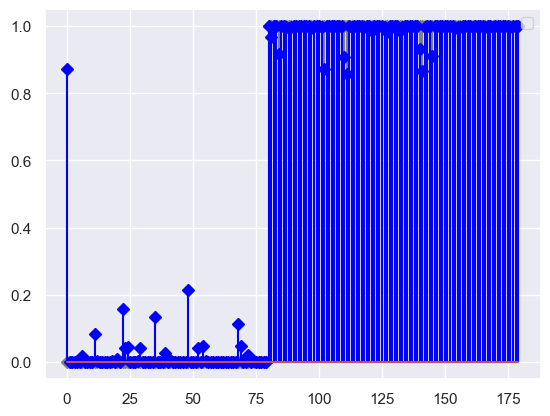

In [20]:
from tqdm import tqdm

# 2 inputs, 1 output, and init with our clusters
net = RBFnet(clusters)

# criteria function, sum of squared error
criterion = nn.MSELoss()
# lets just go with stochastic gradient descent
#optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

# Train the model
num_epochs = 200
for epoch in tqdm(range(num_epochs),'Training Epochs'): # train for num_epochs     
    for samples, labels in train: # our mini batch sampling
        
        # Forward pass
        outputs = net(samples) # what outputs given our current weights?    
        loss = criterion(outputs, labels) # evaluate the loss

        # Backward error and optimize!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Plot the graph
predicted = net(torch.from_numpy(xtest)).detach().numpy()
plt.stem(ytest, linefmt ='grey', markerfmt ='D')
plt.stem(predicted, linefmt ='blue', markerfmt ='D')
plt.legend()
plt.show()

What were the final net parameters?

In [21]:
print(list(net.parameters())) # print var values

[Parameter containing:
tensor([5., 5., 5., 5., 5., 5., 5., 5., 5.], dtype=torch.float64), Parameter containing:
tensor([[ -0.3141,  -5.9469],
        [ -1.5565,   4.4222],
        [-10.0356,  -3.9280],
        [  5.5798,  -4.4464],
        [ -7.0617,  -8.0735],
        [  0.5201,  -2.6164],
        [ -6.2988,  -3.1321],
        [ -3.1175,   0.4279],
        [ -4.2523,   4.7536]], dtype=torch.float64), Parameter containing:
tensor([ 36.9325, -39.1816, -13.8827,   5.0049, -61.9195, -18.2089,  23.7052,
          7.4555,  32.2499], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.6195], dtype=torch.float64, requires_grad=True)]


What if we go right after it with LMS?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


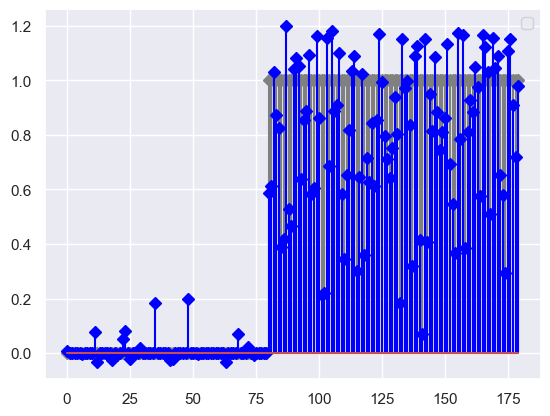

In [23]:
import math
from numpy.linalg import inv

# lets run our data through our radial basis functions
def eval_on_data(x,clusters):
    # evaluate RBFs
    # you could do some matrix math and get rid of this for loop!!!!
    res = np.zeros((x.shape[0],clusters.shape[0]))
    for i in range(x.shape[0]): # each data point
        for j in range(clusters.shape[0]): # each cluster
            top = np.sqrt(((x[i,:]-clusters[j,:])**2).sum(axis=0))
            res[i,j] = np.exp( (-0.5) * ( math.pow(top,2.0) / math.pow(1.0,2.0) ) ) # sigma = 1 assumption here
    return res
            
outputs = eval_on_data(xtrain,clusters)

# our target output values are 
#  ytrain

# use a LMS solver to determine our weights
#  A_psinv = inv(tran(A) * A) * tran(A)
PSINV = np.matmul( inv( np.matmul(outputs.transpose(),outputs) ), outputs.transpose() )
weights = np.matmul( PSINV, ytrain )

# eval now on this
testres = np.zeros(xtest.shape[0])
for i in range(xtest.shape[0]): # each sample
    code = np.zeros(clusters.shape[0])
    for j in range(clusters.shape[0]): # each cluster
        top = np.sqrt(((xtest[i,:]-clusters[j,:])**2).sum(axis=0))
        code[j] = np.exp( (-0.5) * ( math.pow(top,2.0) / math.pow(1.0,2.0) ) ) # sigma = 1 assumption here
    # now, mult by our weights
    testres[i] = np.dot( code, weights )
plt.stem(ytest, linefmt ='grey', markerfmt ='D')
plt.stem(testres, linefmt ='blue', markerfmt ='D')
plt.legend()
plt.show()